In [4]:
import tensorflow
import pandas as pd
import time
import numpy as np

# tensorflow libraries
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots


# sklearn libraries are useful for preprocessing, performance measures, etc.
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import numpy as np
import pylab as plt
import multiprocessing as mp

# Part A: Classifications

# Read Data

In [5]:
df = pd.read_csv('./dataset/features_30_sec.csv')
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [6]:
df['label'].value_counts()

blues        100
classical    100
country      100
disco        100
hiphop       100
jazz         100
metal        100
pop          100
reggae       100
rock         100
Name: label, dtype: int64

In [7]:
columns_to_drop = ['label','filename', 'length']

def prepare_dataset(df, columns_to_drop, test_size, random_state):

    # Encode the labels from 0 to n_classes-1  
    label_encoder = preprocessing.LabelEncoder()
    df['label'] = label_encoder.fit_transform(df['label'])
  
    # devide data to train and test
    df_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)
    
    # scale the training inputs
    x_train = df_train.drop(columns_to_drop,axis=1)
    y_train = df_train['label'].to_numpy()
    
    standard_scaler = preprocessing.StandardScaler()
    x_train_scaled = standard_scaler.fit_transform(x_train)

    #scale and prepare testing data
    x_test = df_test.drop(columns_to_drop,axis=1)
    x_test_scaled = standard_scaler.transform(x_test)
    y_test = df_test['label'].to_numpy() 
  
    return x_train_scaled, y_train, x_test_scaled, y_test


Import training modules. Split and scale dataset.

In [8]:
from PartA_train import *

X_train, Y_train, X_test, Y_test = prepare_dataset(df, columns_to_drop, test_size=0.3, random_state=0)

Y_train = tf.keras.utils.to_categorical(Y_train)
Y_test = tf.keras.utils.to_categorical(Y_test)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(700, 57) (700, 10)
(300, 57) (300, 10)


# Q1

Design a feedforward deep neural network (DNN) which consists of an input layer, one
hidden layer of 16 neurons with ReLU activation function, and an output softmax layer.
Use an stochastic gradient descent with ‘adam’ optimizer with default parameters, and
batch size = 1. Apply dropout of probability 0.3 to the hidden layer.
Divide the dataset into a 70:30 ratio for training and testing. Use appropriate scaling of
input features. We solely assume that there are only two datasets here: training & test.
We would look into validation in Question 2 onwards.

## Creating the model

In [9]:
class PartA_DNN():
    # init
    def __init__(self,
        learning_rate = 0.001,
        batch_size = 1,
        dropout = 0.3,
        seed = 100,
        num_epochs = 50
        ):
        self.seed = seed
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.dropout = dropout
        self.num_epochs = num_epochs
        np.random.seed(self.seed)
        tf.random.set_seed(self.seed)
        self.model = Sequential([
            Dense(16, activation='relu'),
            Dropout(rate = self.dropout),
            Dense(10, activation='softmax')
        ])
    
    def train(self, X_train, Y_train, X_test, Y_test):
        self.model.compile(optimizer = Adam(learning_rate = self.learning_rate),
                            loss = tf.keras.losses.MeanSquaredError(),
                            metrics = ['accuracy'])
                            
        history = self.model.fit(X_train, Y_train,
                            # shuffle = True,
                            epochs = self.num_epochs, 
                            verbose = 2,
                            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=10),
                                        tfdocs.modeling.EpochDots()],
                            validation_data=(X_test, Y_test)
                            )
        return history
    
    def train_kfold(self, kfold_input, kfold_target, train, test):
        self.model.compile(optimizer = Adam(learning_rate = self.learning_rate),
                            loss = tf.keras.losses.MeanSquaredError(),
                            metrics = ['accuracy'])
                            
        history = self.model.fit(kfold_input[train], kfold_target[train],
                            epochs = self.num_epochs, 
                            verbose = 2,
                            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=10),
                                        tfdocs.modeling.EpochDots()],
                            validation_data=(X_test, Y_test)
                            )

        scores = self.model.evaluate(kfold_inputs[test], kfold_targets[test], verbose=2)
        acc_per_fold.append(scores[1] * 100)
        loss_per_fold.append(scores[0])

        return history, acc_per_fold, loss_per_fold
    
    def view_summary(self):
        return self.model.summary()


## Training Data

Import model and set model configurations

## Q1.a

Use the training dataset to train the model for 50 epochs. Note: Use 50
epochs for subsequent experiments.

In [8]:
model = Sequential([
            Dense(16, activation='relu'),
            Dropout(rate = 0.3),
            Dense(10, activation='softmax')
        ])

model.compile(optimizer = Adam(learning_rate = 0.001),
                            loss = tf.keras.losses.MeanSquaredError(),
                            metrics = ['accuracy'])
                            
history = model.fit(X_train, Y_train,
                    # shuffle = True,
                    epochs = 50, 
                    verbose = 2,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=10),
                                tfdocs.modeling.EpochDots()],
                    validation_data=(X_test, Y_test)
                    )

2021-10-07 15:10:34.469660: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-07 15:10:34.575086: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
22/22 - 2s - loss: 0.0966 - accuracy: 0.0971 - val_loss: 0.0912 - val_accuracy: 0.1333

Epoch: 0, accuracy:0.0971,  loss:0.0966,  val_accuracy:0.1333,  val_loss:0.0912,  
.Epoch 2/50
22/22 - 0s - loss: 0.0927 - accuracy: 0.1314 - val_loss: 0.0880 - val_accuracy: 0.2200
.Epoch 3/50
22/22 - 0s - loss: 0.0888 - accuracy: 0.1914 - val_loss: 0.0857 - val_accuracy: 0.2633
.Epoch 4/50
22/22 - 0s - loss: 0.0862 - accuracy: 0.2486 - val_loss: 0.0834 - val_accuracy: 0.2900
.Epoch 5/50
22/22 - 0s - loss: 0.0831 - accuracy: 0.2500 - val_loss: 0.0814 - val_accuracy: 0.3200
.Epoch 6/50
22/22 - 0s - loss: 0.0800 - accuracy: 0.3329 - val_loss: 0.0794 - val_accuracy: 0.3500
.Epoch 7/50
22/22 - 0s - loss: 0.0777 - accuracy: 0.3414 - val_loss: 0.0777 - val_accuracy: 0.3733
.Epoch 8/50
22/22 - 0s - loss: 0.0757 - accuracy: 0.3629 - val_loss: 0.0759 - val_accuracy: 0.4067
.Epoch 9/50
22/22 - 0s - loss: 0.0745 - accuracy: 0.3829 - val_loss: 0.0743 - val_accuracy: 0.4133
.Epoch 10/50
22/22 - 0s - 

## Q1.b

Plot accuracies on training and test data against training epochs and
comment on the plots.

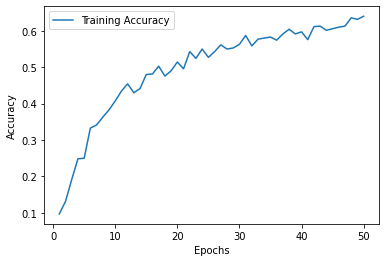

In [9]:
epochs = range(1, len(history.history['accuracy'])+1)

plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Accuracy stabilises as loss values reaches convergence

## Q1.C

Plot the losses on training and test data against training epochs. State the
approximate number of epochs where the test error begins to converge.

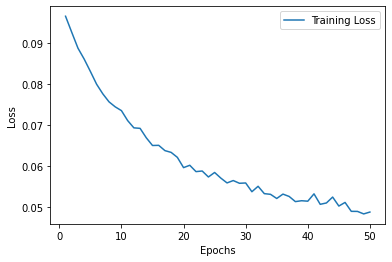

In [10]:
epochs = range(1, len(history.history['loss'])+1)

plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Convergence happens at approximately 48 epochs

# Q2

In this question, we will compare the performance of the model using stochastic gradient
descent and mini-batch gradient descent, as well as determining the optimal batch size
for mini-batch gradient descent. Find the optimal batch size for mini-batch gradient
descent by training the neural network and evaluating the performances for different
batch sizes. Note: Use 3-fold cross-validation on training partition to perform parameter
selection.

## Q2.a

Plot mean cross-validation accuracies over the training epochs for different
batch sizes. Limit search space to batch sizes {1,4,8,16,32, 64}.

In [12]:
model = PartA_DNN()

batch_sizes = [1,4,8,16,32, 64]
kfold = KFold(n_splits = 3, shuffle = True)

kfold_input = np.concatenate((X_train, X_test), axis = 0)
kfold_target = np.concatenate((Y_train, Y_test), axis = 0)

fold_results = []
acc_per_fold = []
loss_per_fold = []

fold = 1
for train, test in kfold.split(kfold_input,  kfold_target):

    for batch in batch_sizes:

        model = Sequential([
                Dense(16, activation='relu'),
                Dropout(rate = 0.3),
                Dense(10, activation='softmax')
            ])

        model.compile(optimizer = Adam(learning_rate = 0.001),
                            loss = tf.keras.losses.MeanSquaredError(),
                            metrics = ['accuracy'])
                            
        history = model.fit(kfold_input[train], kfold_target[train],
                            epochs = 50,
                            verbose = 2,
                            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=10),
                                        tfdocs.modeling.EpochDots()],
                            validation_data=(X_test, Y_test)
                            )

        scores = model.evaluate(kfold_input[test], kfold_target[test], verbose=2)
        acc_per_fold.append(scores[1] * 100)
        loss_per_fold.append(scores[0])

    # history, acc_per_fold, lose_per_fold = model.train_kfold(kfold_input, kfold_target, train, test)
    # fold_results.push({ 'history': history, 'acc_per_fold' : acc_per_fold, 'lose_per_fold': lose_per_fold })
    fold += 1

2021-10-07 15:33:26.329619: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
21/21 - 2s - loss: 0.0968 - accuracy: 0.1066 - val_loss: 0.0913 - val_accuracy: 0.1467

Epoch: 0, accuracy:0.1066,  loss:0.0968,  val_accuracy:0.1467,  val_loss:0.0913,  
.Epoch 2/50
21/21 - 0s - loss: 0.0922 - accuracy: 0.1426 - val_loss: 0.0880 - val_accuracy: 0.2267
.Epoch 3/50
21/21 - 0s - loss: 0.0889 - accuracy: 0.1997 - val_loss: 0.0856 - val_accuracy: 0.2800
.Epoch 4/50
21/21 - 0s - loss: 0.0862 - accuracy: 0.2508 - val_loss: 0.0832 - val_accuracy: 0.3267
.Epoch 5/50
21/21 - 0s - loss: 0.0841 - accuracy: 0.2673 - val_loss: 0.0808 - val_accuracy: 0.3567
.Epoch 6/50
21/21 - 0s - loss: 0.0811 - accuracy: 0.3108 - val_loss: 0.0786 - val_accuracy: 0.3733
.Epoch 7/50
21/21 - 0s - loss: 0.0790 - accuracy: 0.3619 - val_loss: 0.0767 - val_accuracy: 0.4033
.Epoch 8/50
21/21 - 0s - loss: 0.0776 - accuracy: 0.3559 - val_loss: 0.0749 - val_accuracy: 0.4167
.Epoch 9/50
21/21 - 0s - loss: 0.0762 - accuracy: 0.3724 - val_loss: 0.0732 - val_accuracy: 0.4167
.Epoch 10/50
21/21 - 0s - 

NameError: name 'acc_per_fold' is not defined